*Course: Developing the SIR Model  
Institution: Imperical College London  
Presenter: Dr. Nimalan Arinaminpathy*

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Modeling an Infected Cohort

The simplest compartmental model in epidemiology is the `IR` model which keeps track of two populations: those that are infected (compartment $I$) and those that are recovered (compartment $R$). Infected people recover at a rate $\gamma$. The differential equations describing this are $\frac{dI}{dt} = -\gamma I$ and $\frac{dR}{dt} = \gamma R$.

In [2]:
def plot_model(df, times):
    """
    Helper function for plotting
    Assumes df contains columns labeled S, I, R, and/or M
    Returns a graph based on data in the dataframe
    """
    colors = ["b", "r", "g", "k"]
    labels = {"S":"Susceptible", "I":"Infected", "R":"Recovered", "M":"Deceased"}
    f, ax = plt.subplots(figsize=(8,5))
    total_pop = df.iloc[0].sum()
    
    for i, col in enumerate(df.columns):
        ax.plot(times, df[col]/total_pop, colors[i], linewidth=2, label=labels[col])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Proportion of the Population")
    ax.legend()
    return ax.get_figure()

In [3]:
def model(state, t, gamma):
    I = state[0] # number initial infected
    R = state[1] # number initial recovered
    didt = -gamma * I
    drdt = gamma * I
    
    return didt, drdt

In [4]:
def run_model(i_f, i_r, r_r, f_u):
    """
    Inputs: number initial infected, i_f (int)
            number initial recovered, i_r (int)
            recovery rate, r_r (days^-1)
            follow up duration, f_y (days)
    Output: graph of number infected and recovered during the follow-up period
    Returns: plot object and dataframe with number infected and recovered
    """
    times = list(range(0,f_u+1))

    initial_state_values = (i_f, i_r)
    parameters = (r_r,)

    df = pd.DataFrame(odeint(model, initial_state_values, times, args=parameters),
                      columns = ["I", "R"])
    plot_model(df, times)   
    return df

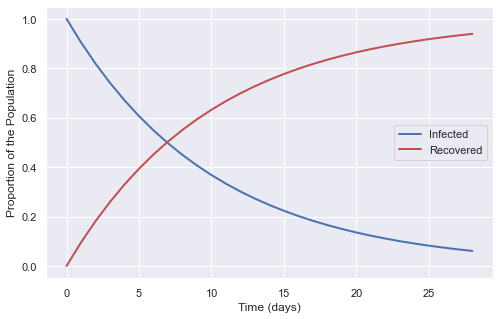

In [5]:
df = run_model(1000000, 0, 0.1, 28) # number infected, number recovered, recovery rate (gamma), days

**Q: Based on the output, how many people have recovered after 4 weeks?**

In [6]:
df[df.index == 28]["R"]

28    939189.937528
Name: R, dtype: float64

**Q: What proportion of the total population does this correspond to?**

In [7]:
df[df.index == 28]["R"]/(df[df.index == 28]["I"]+df[df.index == 28]["R"])

28    0.93919
dtype: float64

**Q: Based on the plot, at what timepoint were infected and recovered individuals (nearly) equal in number?**

In [8]:
min_day = np.abs(df["I"] - df["R"]).idxmin()
df[df.index == min_day]

,I,R
7,496585.302624,503414.697376


#### Varying $\gamma$

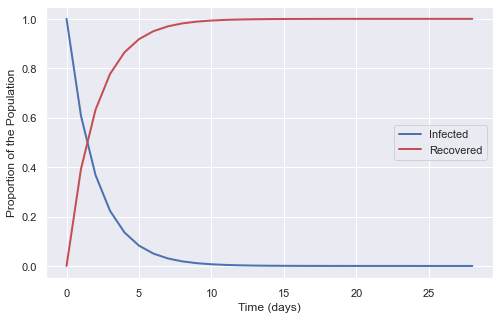

In [9]:
ax, df = run_model(1000000, 0, 0.5, 28)

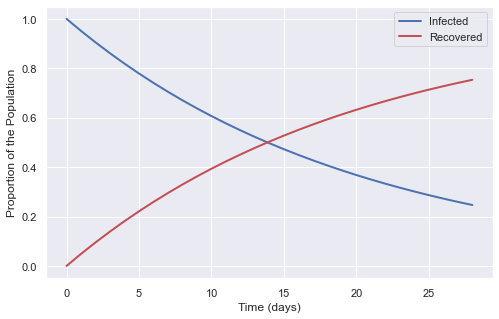

In [10]:
ax, df = run_model(1000000, 0, 0.05, 28)

**Q: What changes do you observe in the transition to the recovered compartment if $\gamma$ is higher or lower? For example, how long does it take for everyone to recover in both cases?**

A: if the rate is higher ($\gamma$ = 0.5), we can see that infected people recover more quickly: it takes less than 2 days for half of the infected cohort to recover, and by around 8 days, nearly everyone has recovered. A lower rate ($\gamma$ = 0.05) on the other hand corresponds to a slower transition: it takes around 14 days for half of infected people to move into the $R$ compartment, and by the end of our 4 week follow-up around a quarter of people still have not recovered.

### 2. Simulating Competing Hazards  
The model we want to specify in this etivity has 3 compartments:  𝐼  (infected),  𝑅  (recovered) and  𝑀  (dead). Like in the first etivity, infected people can recover at a rate  𝛾 . Additionally they can also now die (transition to the  𝑀  compartment) at a rate  𝜇 .

The differential equations for this model look like this:  
$\frac{dI}{dt} = -\gamma I -\mu I$  
$\frac{dR}{dt} = \gamma I$  
$\frac{dM}{dt} = \mu I$

In [11]:
def model2(state, t, parameters):
    
    didt = -parameters[0] * state[0] -parameters[1]*state[0]
    drdt = parameters[0] * state[0]
    dmdt = parameters[1] * state[0]
    
    return didt, drdt, dmdt

In [12]:
initial_infected = 1000000
initial_recovered = 0
initial_dead = 0

recovery_rate = 0.1
mortality_rate = 0.2

follow_up_duration = 28

In [13]:
def run_model2(i_f, i_r, i_d, r_r, m_r, f_u):
    """
    Inputs: number initial infected, i_f (int)
            number initial recovered, i_r (int)
            number initial dead, i_d (int)
            recovery rate, r_r (days^-1)
            mortality_rate, m_r (days^-1)
            follow up duration, f_y (days)
    Output: graph of number infected and recovered during the follow-up period
    Returns: dataframe with number infected, recovered, and deceased
    """
    times = list(range(0,f_u+1))

    initial_state_values = [i_f, i_r, i_d]
    parameters = [r_r, m_r]

    df = pd.DataFrame(odeint(model2, initial_state_values, times, (parameters,)),
                      columns = ["I", "R", "M"])

    plot_model(df, times) 
    
    return df

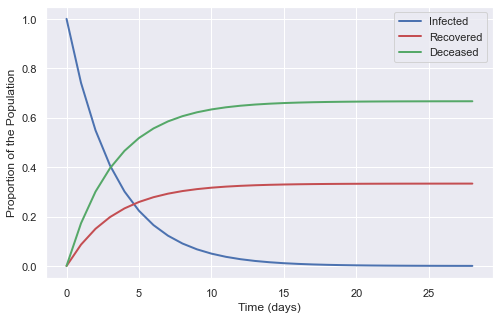

In [14]:
df = run_model2(initial_infected,
                initial_recovered,
                initial_dead,
                recovery_rate,
                mortality_rate,
                follow_up_duration)

**Q: Based on the model output, what proportion of the initially infected cohort died before recovering over the 4 week period?**

In [15]:
round(df[df.index == 28]["M"]/initial_infected, 2)

28    0.67
Name: M, dtype: float64

**Q: Use the competing hazards formula to calculate the case fatality rate. Does this agree with your answer to the previous question? The formula is: $CFR = \frac{\mu}{\mu + \gamma}$.**

In [16]:
cfr = mortality_rate / (mortality_rate + recovery_rate)
print("Case fatality rate:", round(cfr,2))

Case fatality rate: 0.67


**Q: Which value of $\mu$ do you need to get a case fatality rate of 50% assuming $\gamma$ stays fixed?**

In [17]:
# Assuming cfr = 0.5 and $\gamma$ = 0.1
gamma = 0.1; cfr = 0.5
mu = (gamma*cfr)/(1-cfr)
print("Mu:", round(mu,2))

Mu: 0.1


Thus, if $\mu$ and $\gamma$ are equal, they represent two competing hazards that are also equal. Thus, half of people die and half recover, so the case fatality rate is 50%.

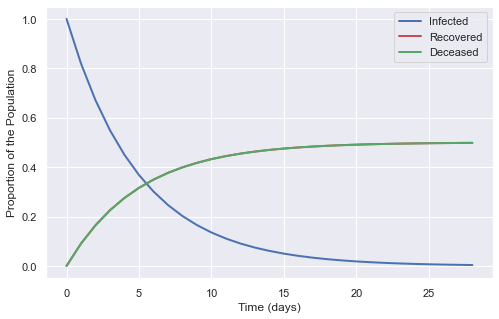

In [18]:
mortality_rate = 0.1

df = run_model2(initial_infected,
                initial_recovered,
                initial_dead,
                recovery_rate,
                mortality_rate,
                follow_up_duration)

We can only see red and blue lines here representing the number of people in the $I$ and $M$ compartment, despite having plotted all 3 compartments. This is because, with $\mu$ = $\gamma$ and $R(0) = M(0)$ (the initial number recovered and deceased), the number of recovered and deceased people is identical at each timestep so the lines completely overlap.

### 3. SIR Model with Constant Force of Infection  
The differential equations for the simple SIR model with a constant force of infection look like this:  
$\frac{dS}{dt} = -\lambda S$  
$\frac{dI}{dt} = \lambda S -\gamma I$  
$\frac{dR}{dt} = \gamma I$

In [19]:
def sir_model(state, t, parameters):
    dsdt = -parameters[0] * state[0]
    didt = parameters[0] * state[0] - parameters[1] * state[1]
    drdt = parameters[1] * state[1]
    
    return dsdt, didt, drdt

In [20]:
from collections import namedtuple

In [21]:
initial_susceptible = 999999
initial_infected = 1
initial_recovered = 0

foi = 0.2 # lambda
recovery_rate = 0.1 # gamma

follow_up_duration = 60

state = (initial_susceptible, initial_infected, initial_recovered)
times = list(range(0,follow_up_duration+1))
parameters = (foi, recovery_rate)

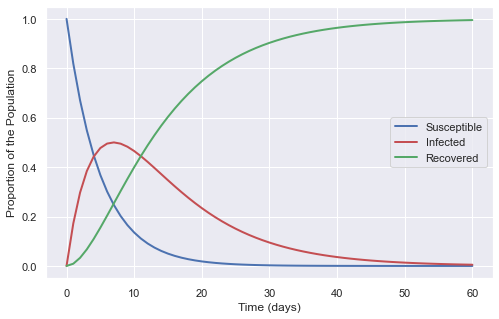

In [22]:
def run_sir_model(state, times, parameters):
    """
    Returns a dataframe containing data from odeint
    Plots a graph
    """
    df = pd.DataFrame(odeint(sir_model, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model(state, times, parameters)

**Q: Based on the plot, describe the pattern of the epidemic over the 2 month period. How does the number of people in the susceptible, infected and recovered compartment change over time? After how many days does the epidemic reach its peak? After how many days does it end?**

The number of infected people quickly increases, reaching a peak of 500000 infected people after around 7 days, before steadily decreasing again. The number of recovered people starts to rise shortly after the first people become infected. It increases steadily (but less sharply than the curve of infected people) until the whole population has become immune - by day 53, 99% are in the R compartment, and nearly no susceptible people remain after 60 days.

### 4. SIR Model with Dynamic Force of Infection  
The differential equations for an SIR model with a dynamic force of infection are:  

$\frac{dS}{dt} = -\beta \frac{I}{N} S$  
$\frac{dI}{dt} = \beta \frac{I}{N} S -\gamma I$  
$\frac{dR}{dt} = \gamma I$  

Some assumptions inherent in this model structure are:  

- a homogeneous population - everyone in the same compartment is subject to the same hazards
- a well-mixed population - all susceptible people have the same risk as getting infected, dependent on the number of - infected people
- a closed population - there are no births or deaths, so the population size stays constant

In [23]:
def sir_model2(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * state[1] / N
    
    dsdt = -lambda_ * state[0]
    didt = lambda_ * state[0] - parameters[1] * state[1]
    drdt = parameters[1] * state[1]
    
    return dsdt, didt, drdt

In [24]:
initial_susceptible = 999999
initial_infected = 1
initial_recovered = 0

beta = 1. # beta
recovery_rate = 0.1 # gamma

follow_up_duration = 60

state = (initial_susceptible, initial_infected, initial_recovered)
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

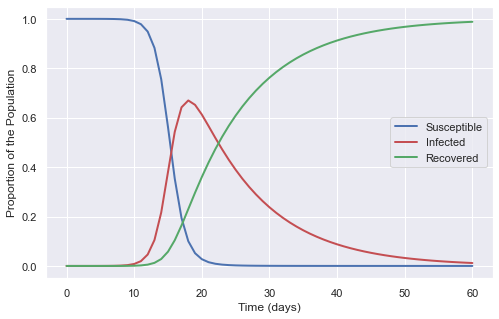

In [25]:
def run_sir_model2(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model2, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model2(state, times, parameters)

**Q: After how many days does the epidemic peak? What is the peak prevalence?**

In [26]:
df[df.index == 19]

,S,I,R
19,51602.69829,651979.270946,296418.030764


**Q: How does the pattern of the epidemic change under different assumptions for $\beta$ and $\gamma$, e.g. in terms of the peak of the epidemic, the number infected at the peak, and when the epidemic ends?**

#### Increasing beta with constant gamma

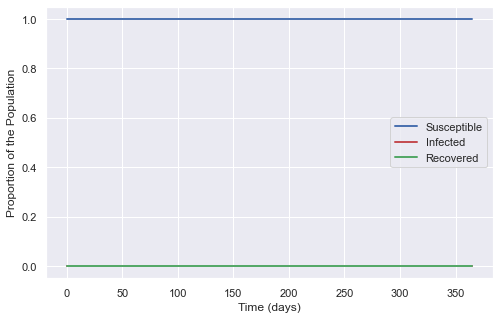

In [27]:
beta =0.1; recovery_rate=0.1; follow_up_duration=365
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

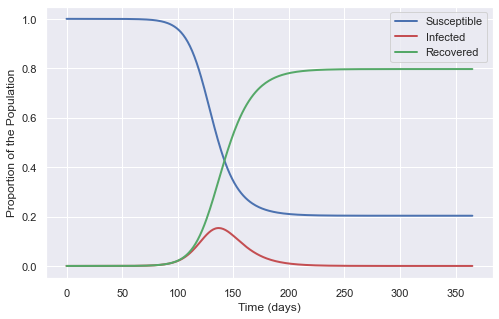

In [28]:
beta =0.2; recovery_rate=0.1; follow_up_duration=365
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

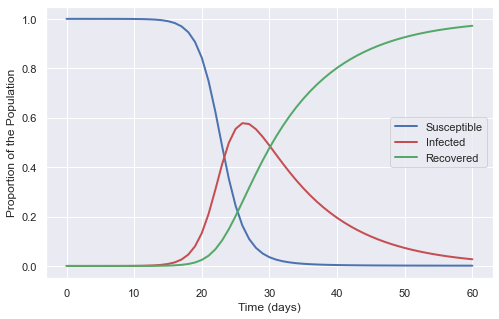

In [29]:
beta =0.7; recovery_rate=0.1; follow_up_duration=60
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

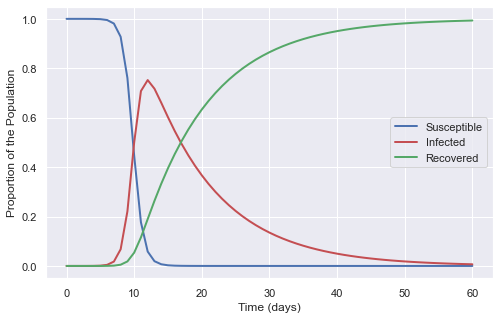

In [30]:
beta =1.5; recovery_rate=0.1; follow_up_duration=60
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

With $\gamma$ held constant at 0.1, an increasing value for $\beta$ leads to an earlier and higher peak of infected people. With a higher $\beta$, the peak is also "sharper", i.e. the epidemic also starts to decline again more quickly. A $\beta$ of 0.1 actually does not give rise to an epidemic: the number of susceptible, infected and recovered people stays the same as at the beginning.

#### Constant beta with increasing gamma

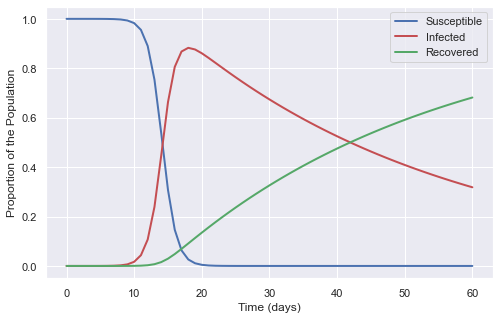

In [31]:
beta =1; recovery_rate=0.025; follow_up_duration=60
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

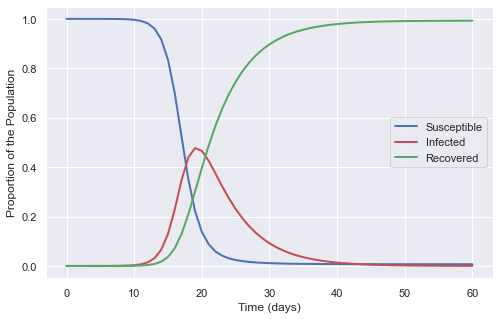

In [32]:
beta =1; recovery_rate=0.2; follow_up_duration=60
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

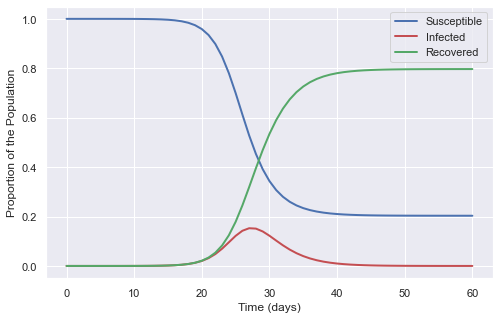

In [33]:
beta =1; recovery_rate=0.5; follow_up_duration=60
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

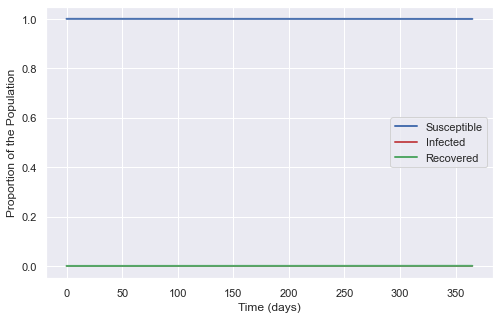

In [34]:
beta =1; recovery_rate=1; follow_up_duration=365
times = list(range(0,follow_up_duration+1))
parameters = (beta, recovery_rate)

df = run_sir_model2(state, times, parameters)

As you can see, different recovery rates affect the epidemic just as much as different forces of infection. With $\beta$ held constant at 1, an increasing value for $\gamma$ tends to lead to a later and lower peak of infected people, and an earlier rise in the recovered curve. If people can stay infected for a long time before recovering ($\gamma$ = 0.025, corresponding to an average duration of infection of 40 days), the number of infected people stays high over a longer period and declines slowly - the epidemic flattens out. In contrast, if recovery happens very quickly after infection ($\gamma$ = 0.5), there is a only small peak in the prevalence of infection and the epidemic dies out quickly. If $\gamma$ is as large as 1, no epidemic takes place after the introduction of 1 infected case.

### 5. SIR Dynamics with Varying Parameters  

We are modelling a disease where every infectious person infects 1 person on average, every 2 days, and is infectious for 4 days.  

$\beta$ = 1 person/2 days = 0.5 days$^{-1}$  
$\gamma$ = 1/4 = 0.25 days$^{-1}$

**Modelling this epidemic for a duration of 100 days:**

In [35]:
state = (1000000-1, 1, 0)
times = list(range(0, 100+1))
parameters = (0.5, 0.25)

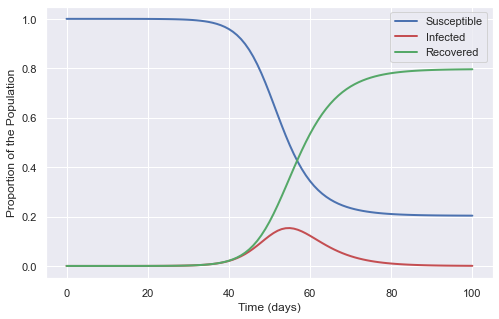

In [36]:
df = run_sir_model2(state, times, parameters)

**Q: What do you observe when $\beta$ = 0.5 and $\gamma$ = 0.25?**

An epidemic occurs, reaching a peak 56 days after introduction of the first infectious case, at which point about 15% of the population are infected. By the end of the epidemic, about 80% of the population have been infected and recovered.  

**Q: What happens when $\beta$ is decreased to 0.1 because a control infection measure is introduced?**

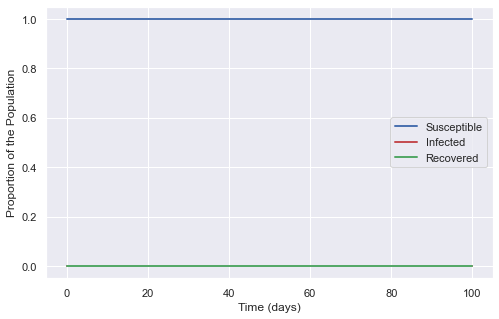

In [37]:
# Decrease beta to 0.1
parameters = (0.1, 0.25)
df = run_sir_model2(state, times, parameters)

Under this set of conditions, no epidemic occurs - the number of infected people does not increase following the introduction of a first infectious case.

**Q: Assuming $\beta$ equals 0.1, what value of $\gamma$ do you need in order to get an epidemic? In real life, what could give rise to this change in $\gamma$?**

In [38]:
beta = 0.1
follow_up_duration = 1000

times = list(range(0,follow_up_duration+1))
for gamma in [0.1, 0.09, 0.05, 0.01]:
    parameters = (beta, gamma)
    df = pd.DataFrame(odeint(sir_model2, state, times, (parameters,)), columns=["S", "I", "R"])
    print("\nRatio of beta to gamma:", round(beta/gamma,2))
    print("Gamma of " +str(gamma), "Maximum Number of Infected People:", np.round(df["I"].max()), "at", df["I"].idxmax(), "days.")


Ratio of beta to gamma: 1.0
Gamma of 0.1 Maximum Number of Infected People: 1.0 at 0 days.

Ratio of beta to gamma: 1.11
Gamma of 0.09 Maximum Number of Infected People: 5176.0 at 999 days.

Ratio of beta to gamma: 2.0
Gamma of 0.05 Maximum Number of Infected People: 153416.0 at 274 days.

Ratio of beta to gamma: 10.0
Gamma of 0.01 Maximum Number of Infected People: 669741.0 at 180 days.


With $\gamma$ around 0.09 or lower, we start to see a small epidemic if we run the model for long enough (ca. 1000 days). Different mechanisms can lead to such a decrease in the recovery rate, corresponding to an increase of the average infectious period, for example strain evolution of the infectious agent or changes in social behaviour.

**Q: Based on your answers to the previous question, can you think of a condition involving $\beta$ and $\gamma$ that is necessary for an epidemic?**

For an epidemic to happen, the ratio $\beta$/$\gamma$ has to be greater than 1. In other words, to give rise to an epidemic, infectious people have to be **infectious enough** ($\beta$ has to be high enough) for **long enough** ($\gamma$ has to be low enough) to pass on the pathogen - $\beta$ has to be higher than $\gamma$. Because of the relationship between these two parameters, a low infection rate can still lead an epidemic if infected people are infectious for long enough, as you modelled in the previous question.

### 6. Simulating the effective reproduction number $R_{eff}$.

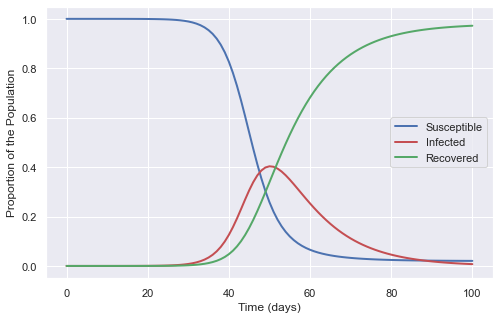

In [39]:
beta = 0.4; gamma = 0.1
follow_up_duration = 100

times = list(range(0,follow_up_duration+1))
parameters = (beta, gamma)

df = run_sir_model2(state, times, parameters)

#### Calculating $R_{eff}$.

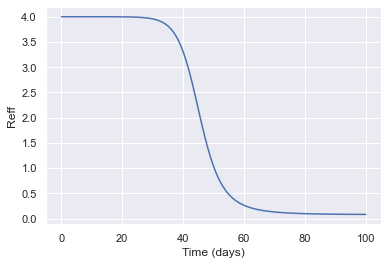

In [40]:
r_eff = beta/gamma * (df["S"]/df.sum(axis=1))
plt.plot(times, r_eff)
plt.xlabel("Time (days)")
plt.ylabel("Reff");

**Q: How does $R_{eff}$ vary over the course of the epidemic? What do you notice about the connection between the change in $R_{eff}$ and the epidemic curve over time? In particular, in relation to $R_{eff}$, when does the epidemic peak and start to decline?**

The effective reproduction number is highest when everyone is susceptible: at the beginning, R<sub>eff</sub> = R<sub>0</sub>. At this point in our example, every infected cases causes an average of 4 secondary infections. Over the course of the epidemic, R<sub>eff</sub> declines in proportion to susceptibility. 

The peak of the epidemic happens when R<sub>eff</sub> goes down to 1 (in the example here, after 50 days). As R<sub>eff</sub> decreases further below 1, the epidemic prevalence goes into decline. This is exactly what you would expect, given your understanding of the meaning of R<sub>eff</sub>: once the epidemic reaches the point where every infected case cannot cause at least one more infected case (that is, when R<sub>eff</sub> < 1), the epidemic cannot sustain itself and comes to an end.

__________________

**Prevalence**, sometimes referred to as prevalence rate, is the proportion of persons in a population who have a particular disease or attribute at a specified point in time or over a specified period of time. Prevalence differs from incidence in that prevalence includes all cases, both new and preexisting, in the population at the specified time, whereas incidence is limited to new cases only.  

**Incidence** refers to the occurrence of new cases of disease or injury in a population over a specified period of time.

### 7. Modeling Population Turnover  
In the previous SIR model, we assumed a closed population, i.e. one where no one dies and no babies are born. In terms of the epidemic dynamics, that has meant that as more and more people become infected and recovered, the pool of susceptibles continually decreases, and thus so too does the effective reproduction number. This is fine for diseases with short infectious periods, that spread through a population more quickly than the population is able to renew itself. But what about longer timescales? Here, we want to incorporate births and deaths into the basic SIR model. The structure for this model looks like this:

<img src="w4_nb1_model_diagram.png"/>

**Q: What are the differential equations for this model?. What are the underlying assumptions regarding births and deaths?**

\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S - \mu S + bN \\
\frac{dI}{dt} & = \beta \frac{I}{N} S - \gamma I - \mu I \\
\frac{dR}{dt} & = \gamma I - \mu R
\end{align}

This structure assumes that every individual in each compartment experiences the same background mortality $\mu$ (there is no additional mortality from the infection for example, and we make no distinction by age). Those who have died no longer contribute to infection (a sensible assumption for many diseases). Babies are all born at a rate *b* into the susceptible compartment. 

Note that, as always, we calculate the people dying in each of the compartments by multiplying the number in that compartment by the rate $\mu$. Even though babies are all born into the same compartment, the birth rate still depends on the population in all of the compartments, hence why we need to multiply *b* by the total population size *N*. Here, we choose a value of *b* to allow a constant population size, so that all deaths are balanced by births.

In [41]:
beta = 0.4
gamma = 0.2

num_years = 400

mu = 1/(70*365)
b = 1/(70*365)
follow_up_duration = 365*num_years

In [42]:
state = (1000000-1, 1, 0) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
#times = list(np.linspace(0, 400, num=400*365/2, retstep=2/365)[0])
parameters = (beta, mu, b, gamma)

The SIR model is extended to capture mortality and births. In the previous model instance, we are looking at an acute disease epidemic introduced into a fully susceptible human population. The infection and recovery rates are 0.4 and 0.2 days$^{-1}$ respectively. We can calculate the background mortality rate based on the average human lifespan - let's assume that this is 70 years, so *mu* = 1/70 years$^{-1}$, or 1/(70x365) days$^{-1}$. In this example, we are also assuming that the population size stays constant over time at 10$^{6}$ - to achieve that, we set the birth rate b = *mu*.

**plot only the number of infected people over time** at this point.

In [43]:
def sir_model3(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * state[1] / N
    
    dsdt = -lambda_ * state[0] - parameters[1] * state[0] + parameters[2] * N
    didt = lambda_ * state[0] - parameters[3] * state[1] - parameters[1] * state[1]
    drdt = parameters[3] * state[1] - parameters[1] * state[2]
    
    return dsdt, didt, drdt

In [44]:
def run_sir_model3(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model3, state, times, (parameters,)), columns=["S", "I", "R"])
    #plot_model(df, times)
    return df

df = run_sir_model3(state, times, parameters)

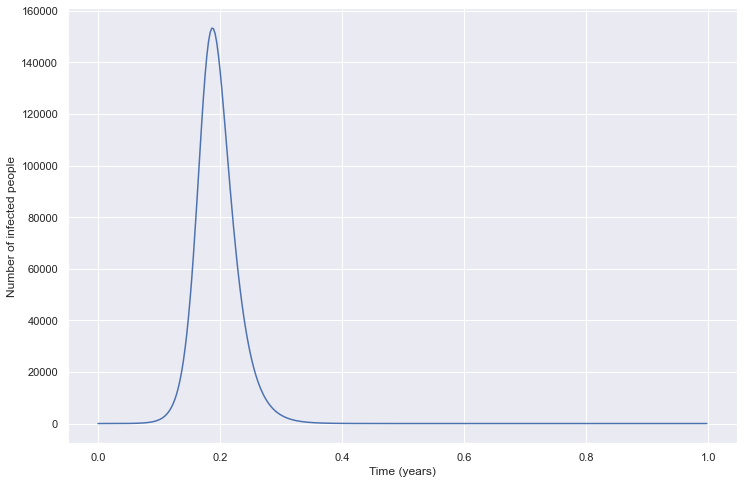

In [45]:
# Plot infected persons in first year only
plt.figure(figsize=(12,8))
plt.plot([x/365 for x in times][:365], df["I"][:365])
plt.xlabel("Time (years)")
plt.ylabel("Number of infected people");

This looks like our typical SIR epidemic curve! In the example above, we solved the differential equations every 2 days.

**Q: How does changing the interval of the timesteps to solve the model at influence the output? Does the plot look correct in each case? If not, at what resolution of timesteps do you get erroneous results, and why?**

Changing the timestep vector from seq(from = 0, to = 400, by = 2/365) to: by = 1/365, by = 3/365 and by = 4/365 gives a very similar result in each case. However, if we only solve the equations every 5 days (by = 5/365), we get a nonsensical plot with the y axis showing negative values. deSolve also gives us warning messages that the integration was not successful. This is because, although we are looking at a long timescale, the disease we are modelling still spreads and resolves quickly! The average infectious period is 1/0.2 = 5 days, and the model code needs to have a sufficiently short timestep to capture these dynamics. In this example, a timestep of 5 days is too long, and causes an error where the number of new recoveries at each timestep is larger than the number of infected people. Since the newly recovered individuals ($\gamma * I$) are subtracted from the number currently infected, this eventually leads to negative values in I. 

Something to keep in mind is that, while timesteps of 1, 2, 3 and 4 days all give sensible and very similar results based on the plot, if you print the output you can see that the numbers are actually slightly different. A lower timestep always gives a better resolution, but especially if we work with more complex models, there is a trade-off between the resolution and the computational speed. The choice of timestep therefore also depends on the modeller's priorities, and in practice we are most concerned with which resolution is **good enough** to get reliable predictions.

**Plotting the long-term epidemic curve**

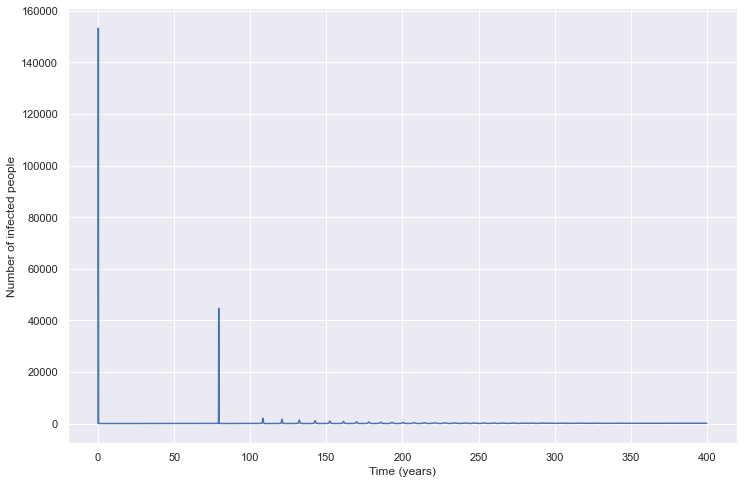

In [46]:
plt.figure(figsize=(12,8))
plt.plot([x/365 for x in times], df["I"])
plt.xlabel("Time (years)")
plt.ylabel("Number of infected people");

**Q: What do you observe about the long-term disease dynamics under these assumptions? Can you explain why this pattern occurs based on what you have learnt in the last weeks?**

Over several generations, we see that the number of infected people oscillates over time. These are sharp epidemic cycles: epidemics reoccur repeatedly over time, although the peaks become progressively smaller and eventually disappear. The first peak is the one we looked at above.

This pattern occurs because the disease has a much shorter duration than the human population turnover. Once an epidemic has spread through the population and depleted the susceptible pool, it takes a long time for the susceptibles to replenish through births. This is why we see these deep and long troughs (around 70 years until the second epidemic) between epidemics. 

We can confirm this by adding susceptible and recovered people to the plot below. As you can see, there are consecutive peaks and troughs in the number of susceptible and immune people as well, with the number in the immune compartment being at its lowest when the number of susceptibles peaks. 

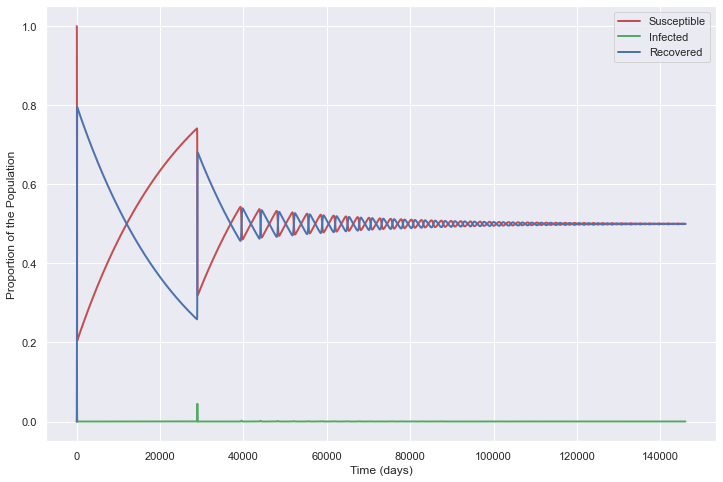

In [47]:
colors = ["r", "g", "b"]
labels = {"S":"Susceptible", "I":"Infected", "R":"Recovered", "M":"Deceased"}
f, ax = plt.subplots(figsize=(12,8))
total_pop = df.iloc[0].sum()


for i, col in enumerate(df.columns):
    ax.plot(times, df[col]/total_pop, colors[i], linewidth=2, label=labels[col])
    #ax.plot(times, df["R"], 'b', linewidth=2, label="Recovered")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Proportion of the Population")
ax.legend();

Once the proportion of susceptibles is sufficiently high for infection to spread, the number of infected people starts rising. Just before the peak of the epidemic, more susceptibles are removed through infection than are added through births, so the susceptible proportion starts going into decline again. Remember, the epidemic peaks when the effective reproduction number equals 1 - and in the simple SIR model, the effective reproduction number is directly proportional to the proportion of susceptibles through the formula: 

\begin{align}
R_{eff} = R_{0} \frac{S}{N}
\end{align}

By rearranging the equation, we see that the epidemic peaks when the proportion of susceptibles $S/N = 1/R_{0}$. In our example R<sub>0</sub> = 0.4/0.2 = 2. Indeed, we can see that the peaks in the number of infectious people occur when the proportion susceptible equals 0.5. After that, the proportion of susceptibles becomes too low for each infectious person to cause at least one secondary case on average - the prevalence of infection decreases and the epidemic ends, until the pool of susceptibles is replenished again.

If you were to plot Reff, you would see it follows the same pattern as the proportion in the susceptible compartment.

In the second example, we are modelling a similar acute disease, but this time in a population with much faster turnover. The infection parameters are the same as before, but we are assuming the average lifespan is 4 weeks.

**Modelling this population over 1 year**

In [48]:
beta = 0.4
gamma = 0.2

num_years = 1

mu = 1/28
b = 1/28
follow_up_duration = 365*num_years

In [49]:
state = (1000000-1, 1, 0) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, mu, b, gamma)

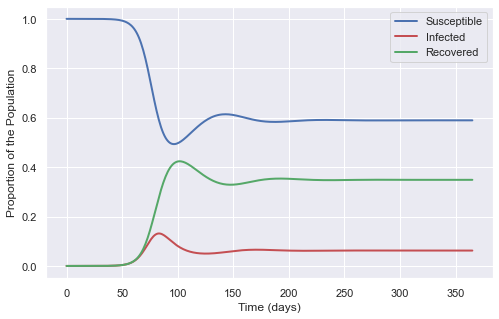

In [50]:
def run_sir_model3(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model3, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model3(state, times, parameters)

**Q: How do the disease dynamics compare to the previous example? Why does this occur (what is different compared to the disease in the human population)?**

In the rapid-turnover population, we don't observe epidemic cycles like in the slow-turnover example. Instead, an epidemic occurs after about 80 days of introduction of an infectious case. After the peak, the prevalence of infection starts to decline - but this time not to 0! After the epidemic, the prevalence of susceptibles, infected and recovered people reaches a stable equilibrium, where around 6% remain infected. When the system is in equilibrium, we refer to this as **endemicity**. As opposed to an epidemic, an endemic infection does not die out but remains stable within a population. 

In this example, an acute disease with the same infection parameters becomes endemic in the pig population because the population turnover is much faster compared to humans. The susceptible pool is replenished quickly through new births, so infectious individuals can cause at least 1 secondary case on average throughout. You should see that the proportion susceptible remains stable at a value > 0.5.  

In the plot below, you can see how this corresponds to the effective reproduction number:

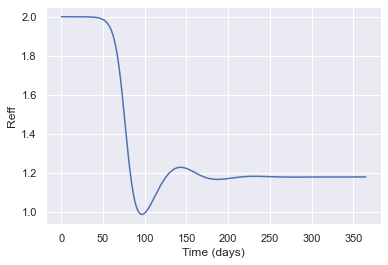

In [51]:
r_eff = beta/gamma * (df["S"]/df.sum(axis=1))
plt.plot(times, r_eff)
plt.xlabel("Time (days)")
plt.ylabel("Reff");

## Additional questions

### Other drivers for epidemic cycles

Several other factors could drive an oscillating pattern in infection dynamics, for example:  
- seasonal transmission, if the epidemics always occur around the same time each year (e.g. measles transmission during the school term, flu transmission in winter)  
- environmental drivers are another very important cause for epidemic cycles, for example with humidity playing an important role in influenza transmission
- stochastic effects 

### Modelling a growing population

For the population to grow, the birth rate needs to be higher than the mortality rate. Another factor affecting the population size could be migration.

#### Modelling a disease where a proportion *p* of babies born to infected mothers are infected at birth

To model mother-to-child transmission, we need to capture two aspects:  
1) infected mothers can infect a proportion *p* of their newborns  
2) babies born to uninfected mothers, and a proportion 1-p of babies born to infected mothers, are born into the susceptible compartment  
 

We can define the number of babies infected at birth as:
\begin{align}
births_{i} = p b I 
\end{align}
We can define the number of babies born susceptible as:
\begin{align}
births_{u} = (1-p) b I + b S + b R
\end{align}

Adding this into the differential equations:

\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S - \mu S + births_{u} \\
\frac{dI}{dt} & = \beta \frac{I}{N} S - \gamma I - \mu I  + births_{i}\\
\frac{dR}{dt} & = \gamma I - \mu R
\end{align}


### 8. A Simple Model for Vaccination

**Modelling a disease where $\beta$ = 0.4 days$^{-1}$, $\gamma$ = 0.1 days $^{-1}$ and the vaccine coverage *p* = 0.5**

In [52]:
p = 0.5
N = 1000000

beta = 0.4
gamma = 0.1

follow_up_duration = 730

state = (((1-p)*(N-1)), 1, p*(N-1)) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma)

In [53]:
def sir_model4(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * state[1] / N
    
    dsdt = -lambda_ * state[0]
    didt = lambda_ * state[0] - parameters[1] * state[1]
    drdt = parameters[1] * state[1]
    
    return dsdt, didt, drdt

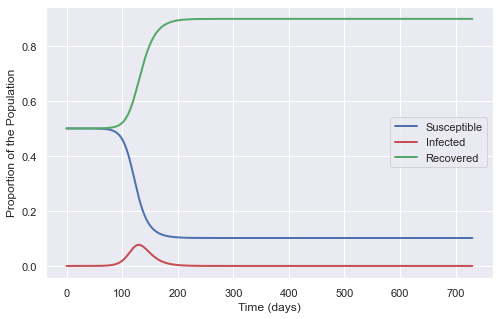

In [54]:
def run_sir_model4(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model4, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model4(state, times, parameters)

**Increasing the vaccine coverage to 75%**

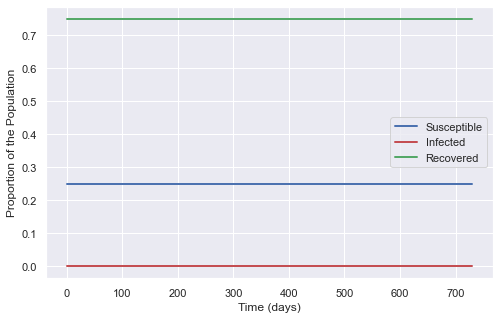

In [55]:
p = 0.75
state = (((1-p)*(N-1)), 1, p*(N-1)) # susceptible, infected, recovered
df = run_sir_model4(state, times, parameters)

**Q: Does everyone in the population need to be vaccinated in order to prevent an epidemic? What do you observe if you model the infection dynamics with different values for *p*? Can you explain why?**

No, not everyone in the population needs to be vaccinated in order to prevent an epidemic. In this scenario, if *p* equals 0.75 or higher, no epidemic occurs - 75% is the critical vaccination/herd immunity threshold. Remember, herd immunity describes the phenomenon in which there is sufficient immunity in a population to interrupt transmission. Because of this, not everyone needs to be vaccinated to prevent an outbreak.

**Q: What proportion of the population needs to be vaccinated in order to prevent an epidemic if $\beta$ = 0.4 and $\gamma$ = 0.2 days$^{-1}$? What if $\beta$ = 0.6 and $\gamma$ = 0.1 days$^{-1}$?**

If $\beta$ = 0.4 and $\gamma$ = 0.2 days$^{-1}$, the herd immunity threshold is 50%. If $\beta$ = 0.6 and $\gamma$ = 0.1 days$^{-1}$, the required vaccination coverage is around 83%.

In [56]:
min_infected = 1

beta = 0.4; gamma=0.2
parameters = (beta, gamma)

for perc_vacc in [0.4, 0.45, 0.5, 0.55]:
    state = (((1-perc_vacc)*(N-1)), 1, perc_vacc*(N-1))
    df = pd.DataFrame(odeint(sir_model4, state, times, (parameters,)), columns=["S", "I", "R"])
    if df["I"].max() <= min_infected:
        print("No epidemic with at least " + str(round(perc_vacc*100))+"% vaccination")
        break

No epidemic with at least 50% vaccination


In [57]:
beta = 0.6; gamma=0.1
parameters = (beta, gamma)

for perc_vacc in [0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9]:
    state = (((1-perc_vacc)*(N-1)), 1, perc_vacc*(N-1))
    df = pd.DataFrame(odeint(sir_model4, state, times, (parameters,)), columns=["S", "I", "R"])
    if df["I"].max() <= min_infected:
        print("No epidemic with at least " + str(round(perc_vacc*100))+"% vaccination")
        break

No epidemic with at least 85% vaccination


**Q: Remember that vaccination changes the effective reproduction number, by reducing the number of people who are susceptible. Based on your answers to the previous questions, can you use the formula for the effective reproduction number R<sub>eff</sub> to derive a formula for calculating the critical vaccination threshold?**

In mathematical modelling terms, herd immunity is just the same as saying that R<sub>eff</sub> < 1. We can derive the herd immunity threshold by solving the formula for R<sub>eff</sub> for *p* when R<sub>eff</sub> = 1:

\begin{align}
R_{eff} & = R_{0} \frac{S}{N} \\
R_{eff} & = R_{0} (1-p) \\
p = 1-\frac{1}{R_{0}}
\end{align}

Remember, we can calculate R<sub>0</sub> by dividing $\beta$ by $\gamma$.

### 9. Modeling waning immunity

In [58]:
beta = 0.4         # infection rate (days^-1)
gamma = 0.2        # recovery rate (days^-1)
sigma = 1/(10*365) # rate of waning immunity (0.1 year^-1)

num_years = 100

follow_up_duration = 365*num_years

state = (1000000-1, 1, 0) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, sigma)

In [59]:
def sir_model5(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * state[1] / N
    
    dsdt = -lambda_ * state[0] + parameters[2] * state[2]
    didt = lambda_ * state[0] - parameters[1] * state[1]
    drdt = parameters[1] * state[1] - parameters[2] * state[2]
    
    return dsdt, didt, drdt

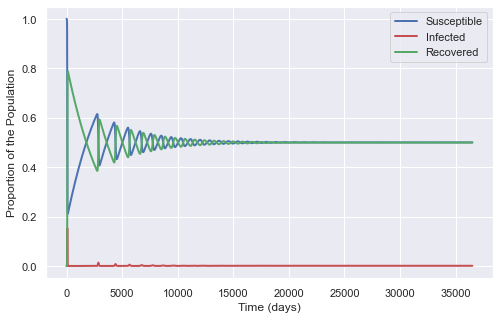

In [60]:
def run_sir_model5(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model5, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model5(state, times, parameters)

**Q: What do you observe about the infection dynamics? How does this compare to the model with population turnover from the first notebook this week?**

When modelling slow waning of immunity, we observe the same epidemic patterns as when we modelled an acute disease in a population with slow turnover: spikes of epidemics alternating with long deep troughs, reflected in the cycles of susceptibility and recovery, but eventually dying out. However, with an average duration of immunity of 30 years, the rate of waning is still quicker than human population turnover, and therefore the time between epidemics is shorter. While in the population turnover example, the source of new susceptibles were births, here it is the people losing their immunity that replenish the susceptible pool.

**Q: What implications would this have for a vaccination programme against this disease?**

Due to waning of vaccine-induced immunity, one-off vaccination of the population is not sufficient to prevent an epidemic in the future. The model predicts a second smaller epidemic occurring about 10 years after vaccination, so it might be necessary to deliver a second booster vaccine within that time period to maintain sufficient herd immunity in the population. However, it is important to note that this model makes many simplifying assumptions and ignores other factors affecting susceptibility in the population, so we cannot draw a conclusion based on this result alone. 

**Changing $\sigma$ to reflect fast waning of immunity:**

In [61]:
sigma = 1/(0.5*365)
num_years = 5
follow_up_duration = 365*num_years

state = (1000000-1, 1, 0) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, sigma)

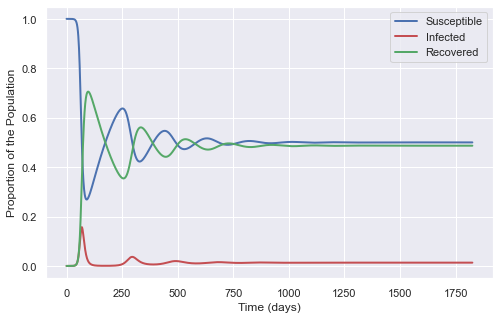

In [62]:
df = run_sir_model5(state, times, parameters)

**Q: What do you observe about the infection dynamics? How does this compare to the model with slow waning of immunity, and with population turnover?**

The outcome under these assumptions is very similar to what we observed when modelling an acute disease in the pig population with fast population turnover. The infection quickly reaches an endemic equilibrium with the effective reproduction number staying stable at just over 1, because just as in the pig population, the pool of susceptibles is continually replenished.

As you can see from both these examples, waning immunity acts in a similar way to the birth rate in the SIR model dynamics. 

**Changing the initial state values to reflect endemicity:**

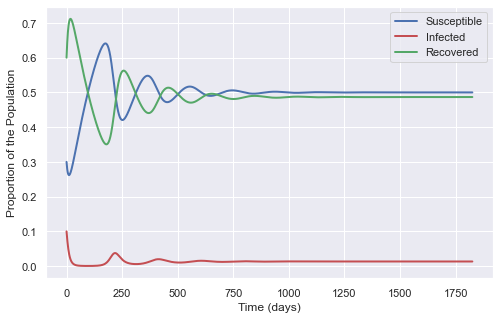

In [63]:
state = (0.3*1000000, 0.1*1000000, 0.6*1000000) # susceptible, infected, recovered
df = run_sir_model5(state, times, parameters)

**Q: What do you observe about the infection dynamics if you change the initial state values?**

As you can see, the system eventually stabilises at the same values as in the previous example where we assumed introduction of a single infected case (although over a slightly different timescale). Generally if we are modelling an endemic infection, with a combination of parameters that leads to a continuous addition of new susceptibles and reaches an endemic equilibrium, the initial number in the compartments we start off with does not affect the endemic prevalence that is eventually reached (as long as there is at least one infected person, of course)!

### 10. Neonatal vaccination to reduce prevalence of an endemic disease in livestock  

#### Setting up the model: 

The SIR structure needs to be extended to incorporate vaccinated births (going into the R compartment), unvaccinated births (going into the S compartment), deaths, and waning immunity. As we are modelling an endemic infection, the initial conditions for the population don't matter as long as they add up to 300000 according to the instructions (this is because all initial conditions will end up at the same endemic equilibrium, given enough time). For the baseline scenario, we are assuming no vaccine coverage (*p_vacc* = 0) and no waning of immunity ($\sigma$ = 0). 

<img src="w4_nb4_model_diagram.png"/>

#### Modelling the baseline (no vaccination) assuming permanent immunity:

In [64]:
N = 300000
S = 0.5*N; I=0.05*N; R=0.45*N

beta = 1       # infection rate
gamma = 1/20   # recovery rate
mu = 1/(3*365) # mortality
b = 1/(3*365)  # birth rate
p_vacc = 0     # neonatal vaccine coverage
sigma = 0      # rate of waning immunity

num_years = 5
follow_up_duration = 365*num_years

state = (S, I, R) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, mu, b, p_vacc, sigma)

In [65]:
def sir_model6(state, t, parameters):
    
    N = (state[0] + state[1] + state[2])
    lambda_ = parameters[0] * state[1] / N
    
    dsdt = -lambda_ * state[0] - parameters[2] * state[0] + (1-parameters[4])*parameters[3]*N + parameters[5] * state[2]
    didt = lambda_ * state[0] - parameters[1] * state[1] - parameters[2] * state[1]
    drdt = parameters[1] * state[1] - parameters[2] * state[2] + parameters[4]*parameters[3]*N - parameters[5] * state[2]
    
    return dsdt, didt, drdt

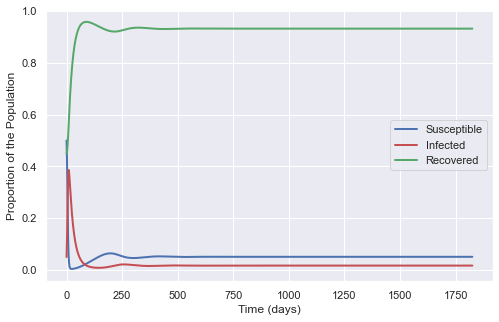

In [66]:
def run_sir_model6(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model6, state, times, (parameters,)), columns=["S", "I", "R"])
    plot_model(df, times)
    return df

df = run_sir_model6(state, times, parameters)

**Q: What is the endemic prevalence of the disease currently (the baseline prevalence), assuming permanent immunity?**

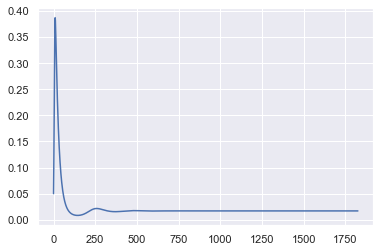

In [67]:
# calculate at 730 days (2 years)
plt.plot(df.index, df["I"]/df.iloc[0,:].sum());

In [68]:
print("Baseline prevalence:", round(df["I"][730]/df.iloc[0,:].sum() * 100, 2))

Baseline prevalence: 1.71


The baseline prevalence is 1.7%.  
From the output, we can also get the number in each compartment at endemic equilibrium and use these as the initial conditions in the vaccine model:

In [69]:
df.loc[730,:]

S     15253.833234
I      5125.043371
R    279621.123395
Name: 730, dtype: float64

### Reducing the prevalence to around 0.85% using the neonatal vaccine, assuming permanent immunity:

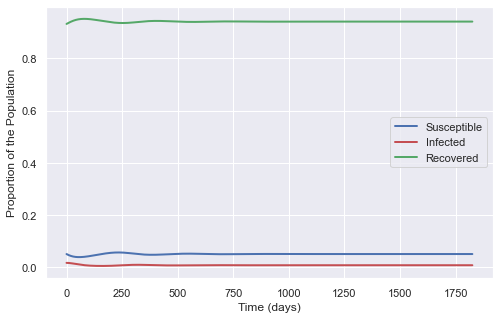

In [70]:
S = 15254; I = 5125; R = 279621
p_vacc = 0.5

state = (S, I, R) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, mu, b, p_vacc, sigma)

df = run_sir_model6(state, times, parameters)

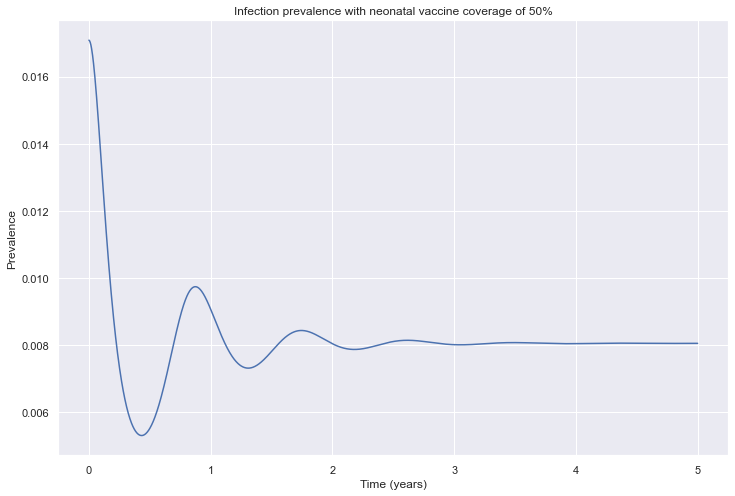

In [71]:
# Calculate and plot prevalence
plt.figure(figsize=(12,8))
plt.plot(df.index/365, df["I"]/df.iloc[0,:].sum())
plt.title("Infection prevalence with neonatal vaccine coverage of 50%")
plt.xlabel("Time (years)")
plt.ylabel("Prevalence");

In [72]:
# Calculating the prevalence in year 5 (introduction of the vaccine at first perturbs the initial equilibrium, but
# we are interested in the new endemic equilibrium achieved with vaccination)
print("Endemic prevalence:", round(df["I"][5*365]/df.iloc[0,:].sum() * 100, 2))

Endemic prevalence: 0.81


**Q: What proportion of newborn animals would you need to vaccinate to reduce the prevalence by half, assuming life-long immunity?**

If immunity  induced by infection and vaccination is lifelong, we only need to vaccinate around 50% of all newborns to achieve a reduction of the endemic prevalence to less than 0.85%.

#### Increasing the vaccine coverage to achieve elimination:

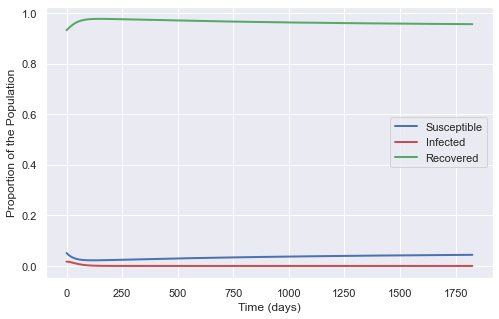

In [73]:
p_vacc = 0.95

parameters = (beta, gamma, mu, b, p_vacc, sigma)

df = run_sir_model6(state, times, parameters)

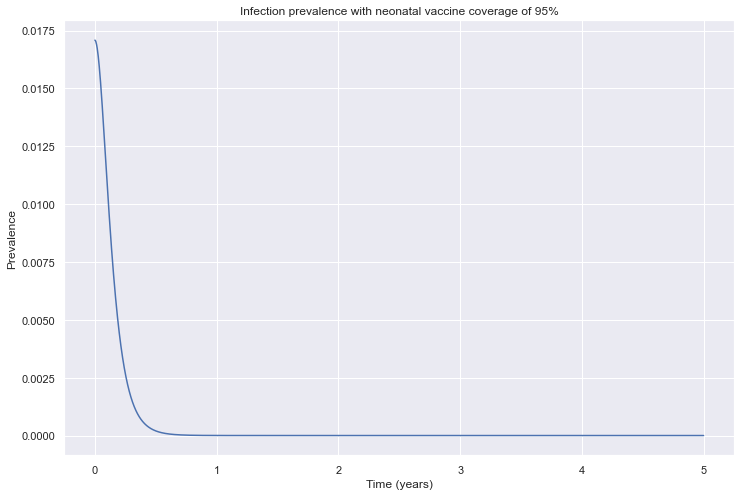

In [74]:
# Calculate and plot prevalence
plt.figure(figsize=(12,8))
plt.plot(df.index/365, df["I"]/df.iloc[0,:].sum())
plt.title("Infection prevalence with neonatal vaccine coverage of 95%")
plt.xlabel("Time (years)")
plt.ylabel("Prevalence");

In [75]:
# Calculating the prevalence in year 5
print("Endemic prevalence:", round(df["I"][5*365]/df.iloc[0,:].sum() * 100, 2))

Endemic prevalence: -0.0


**Q: Would it be possible to eliminate the disease from the population using neonatal vaccination under the assumption of lifelong immunity?**

The model suggests that yes, with a vaccine coverage of 95% or higher, it appears that the disease dies out. We could define elimination as the reduction of prevalence to a certain threshold value. Here, we have simply checked that infection dies out eventually, with a prevalence that tends towards zero over time and less than 1 animal remaining infected at the end of the simulation.

#### Modelling the baseline prevalence and impact of vaccination assuming immunity with an average duration of 1 year:

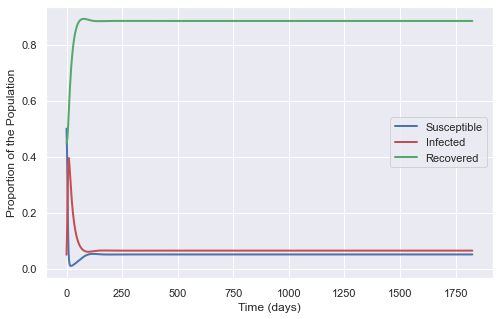

In [76]:
# BASELINE SCENARIO WITH WANING IMMUNITY
N = 1000000
S = 0.5*N; I = 0.05*N; R = 0.45*N

p_vacc = 0; sigma = 1/365

num_years = 5
follow_up_duration = 365*num_years

state = (S, I, R) # susceptible, infected, recovered
times = list(range(0, follow_up_duration+1))
parameters = (beta, gamma, mu, b, p_vacc, sigma)

df_waning_baseline = run_sir_model6(state, times, parameters)

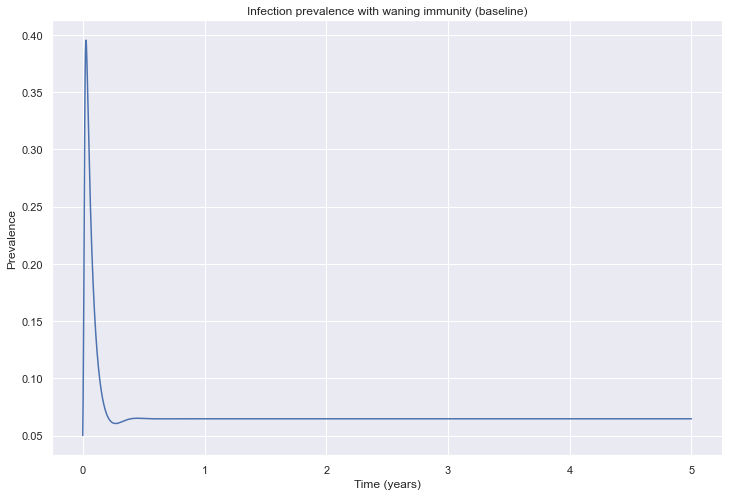

In [77]:
# Calculate and plot prevalence
plt.figure(figsize=(12,8))
plt.plot(df_waning_baseline.index/365, df_waning_baseline["I"]/df_waning_baseline.iloc[0,:].sum())
plt.title("Infection prevalence with waning immunity (baseline)")
plt.xlabel("Time (years)")
plt.ylabel("Prevalence");

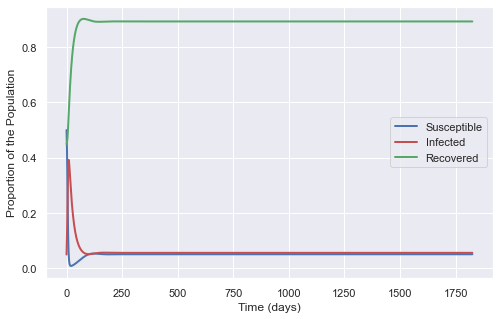

In [78]:
# VACCINE SCENARIO WITH WANING IMMUNITY
p_vacc = 0.5; sigma = 1/365
parameters = (beta, gamma, mu, b, p_vacc, sigma)

df_waning_immunity = run_sir_model6(state, times, parameters)

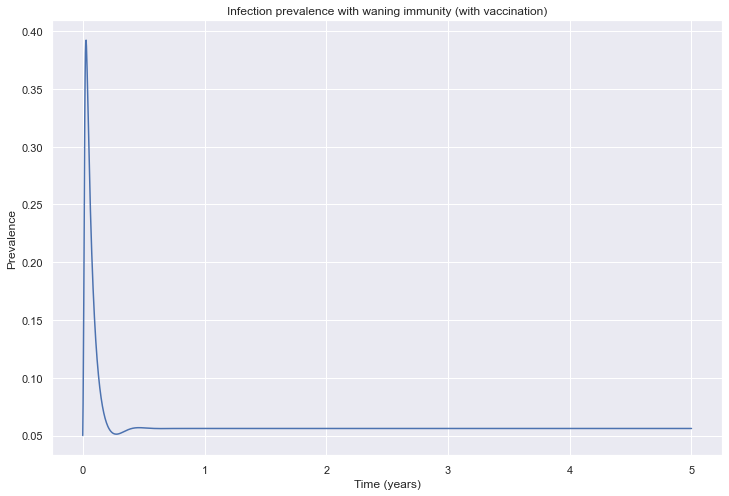

In [79]:
# Calculate and plot prevalence
plt.figure(figsize=(12,8))
plt.plot(df_waning_immunity.index/365, df_waning_immunity["I"]/df_waning_immunity.iloc[0,:].sum())
plt.title("Infection prevalence with waning immunity (with vaccination)")
plt.xlabel("Time (years)")
plt.ylabel("Prevalence");

In [80]:
# Calculating the baseline prevalence with waning immunity
baseline_prev = round(df_waning_baseline["I"][2*365]/df_waning_baseline.iloc[0,:].sum() * 100, 5)
# Calculating the endemic prevalence with waning immunity and neonatal vaccination coverage of 50%
vaccination_prev = round(df_waning_immunity["I"][2*365]/df_waning_immunity.iloc[0,:].sum() * 100, 5)

# Calculating the reduction in prevalence achieved with 50% neonatal vaccine coverage:
print("Reduction in prevalence:", 1- (baseline_prev - vaccination_prev))

Reduction in prevalence: 0.14893


**Q: If the average duration of immunity is only 1 year, how would this impact the proportional reduction in the prevalence with the vaccine coverage you obtained above compared to the baseline?**

If immunity is not permanent but wanes on average after a duration of 1 year in the recovered compartment, a neonatal vaccine coverage of 50% now only leads to a 15% reduction in disease prevalence compared to baseline, rather than 50%. 

#### Modelling the impact of vaccination with 100% coverage assuming immunity with an average duration of 1 year:

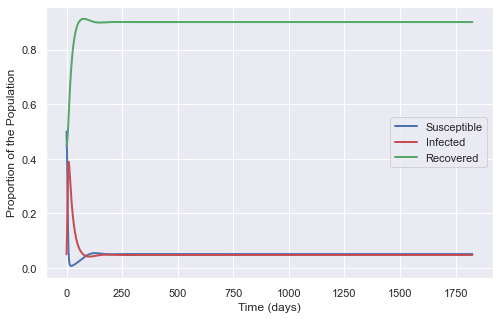

In [81]:
p_vacc = 1; sigma = 1/365
parameters = (beta, gamma, mu, b, p_vacc, sigma)

df_waning_vaccination = run_sir_model6(state, times, parameters)

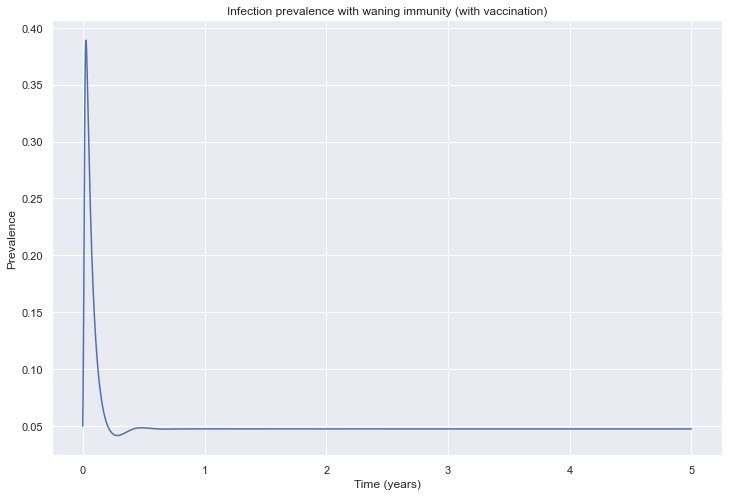

In [82]:
# Calculate and plot prevalence
plt.figure(figsize=(12,8))
plt.plot(df_waning_vaccination.index/365, df_waning_vaccination["I"]/df_waning_vaccination.iloc[0,:].sum())
plt.title("Infection prevalence with waning immunity (with vaccination)")
plt.xlabel("Time (years)")
plt.ylabel("Prevalence");

**Q: Would it be possible to eliminate the disease from the population using neonatal vaccination under these assumptions? What minimum vaccine coverage would this require?**

If immunity only persists for 1 year on average, the model prediction suggests elimination of the disease using neonatal vaccination alone would not be possible. Even with 100% coverage, the prevalence remains at around 5%.

#### Modelling the baseline prevalence and impact of vaccination with 100% coverage assuming immunity with an average duration of 2.5 years:

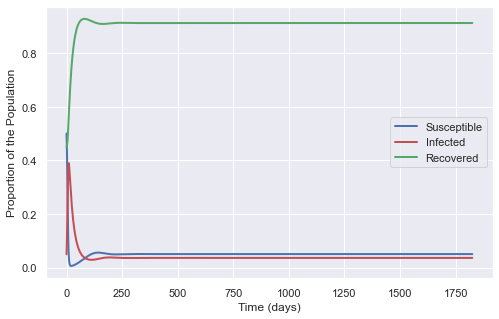

In [83]:
p_vacc = 0
sigma = 1/(2.5*365)

parameters = (beta, gamma, mu, b, p_vacc, sigma)

df_baseline_waning_25 = run_sir_model6(state, times, parameters)
# Calculating the baseline prevalence with slower waning immunity
prev_baseline_waning_25 = df_baseline_waning_25["I"]/df_baseline_waning_25.iloc[0,:].sum()

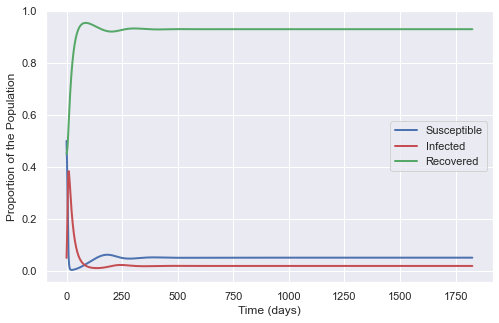

In [84]:
p_vacc = 1
sigma = 1/(2.5*365)

parameters = (beta, gamma, mu, b, p_vacc, sigma)

df_baseline_slow_waning_25 = run_sir_model6(state, times, parameters)
# Calculating the endemic prevalence with slower waning immunity and neonatal vaccination coverage of 100%
prev_baseline_slow_waning_25 = df_baseline_slow_waning_25["I"]/df_baseline_slow_waning_25.iloc[0,:].sum()

**Q: If an adjuvant (a vaccine promoter) was given along with the vaccine, that would extend the duration of immunity to 2.5 years on average, what vaccine coverage would be needed to reduce the baseline prevalence by half? Would it be possible to eliminate the disease from the population under these assumptions using neonatal vaccination?**

If the average duration of immunity was increased to an average of 2.5 years by giving an adjuvant, the baseline prevalence could be reduced to about half (from 3.7% to 1.9%) by achieving a neonatal vaccine coverage of 100%. This means that neonatal vaccination alone is not enough to eliminate the disease from the population as it remains endemic even if every newborn animal is vaccinated. 

In [85]:
print("Baseline prevalence:", prev_baseline_waning_25[2*365])
print("Prevalence with neonatal vaccine coverage of 100%:", prev_baseline_slow_waning_25[2*365])

Baseline prevalence: 0.03666356998902582
Prevalence with neonatal vaccine coverage of 100%: 0.01910499292546926


#### Based on your results, what overall recommendation would you give to the Minister?

The modelling analysis suggests that neonatal vaccination can lead to substantial reductions in endemic prevalence of the disease if recovery and vaccination provide long-term immunity, even if not lifelong. However, the vaccine coverage required to achieve a halving of the endemic prevalence and the impact of the neonatal vaccination in general are strongly dependent on the assumptions we make about waning of immunity. If immunity is only short-term, even perfect coverage of the neonatal vaccine would have limited impact, and elimination of the disease seems only possible if immunity does not wane.

Therefore, the modelling results are inconclusive regarding the current prevalence and the impact of neonatal vaccination until further knowledge on the waning or persistence of immunity becomes available. The Minister could consider investing into further research on this. If neonatal vaccination is implemented and immunity is found to wane quickly, addition of an adjuvant could improve the impact of vaccination.

#### Also provide some information to help the Minister interpret these results. Write down the assumptions in your modelling approach that you think might affect your results. Are there any adaptations you could make to the model structure that would make it more realistic or that would allow you to answer more detailed questions?

The results have shown that the conclusions strongly depend on the assumptions we made about the rate of waning of immunity. Other assumptions that might impact our results are for example:
- we assume vaccination is applied to a proportion *p_vacc* of births at every timestep, i.e. to all newborns all the time
- we assume vaccine-induced immunity and immunity provided by recovery from natural infection confer the same protection and wane at the same time
- we assume transmission is independent of age-mixing, but the vaccine is only given to newborns, so its effect might change depending on the rate at which different age groups transmit and acquire infection

Later we will see how to stratify the model into different age groups, to allow for mixing between these groups. We could also investigate the effect these assumptions have on the result by having separate immune compartments and waning rates for those recovered and those vaccinated. We could also give more information on the timescales of this intervention by modelling the baseline case and vaccine introduction chronologically. In this example, we have only modelled the disease with or without the intervention and compared the prevalence at an arbitrarily chosen timepoint after the system has reached equilibrium. It would be more realistic and informative to model introduction of the vaccine at a specific time after the endemic equilibrium has been reached, i.e. by running the model with *p_vacc* = 0 until the current year and changing *p_vacc* for this timestep onwards to represent introduction of the vaccine. This would allow us for example to investigate how long it takes for prevalence to be reduced by half by the vaccine.

#### Take-home message

Thus, vaccination coverage decisions are affected by a range of population factors, and it can be helpful to see these as different (and sometimes competing) ways of shaping population immunity and susceptibility. Of course, the infection dynamics we see in the real world arise from a combination of many different factors, and the effects of the different susceptibility-shaping mechanisms we covered separately this week might look different when they come together. Model predictions, for example of intervention impact, can vary a lot depending on the assumptions we make about the model structure and the parameter values.